In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import gdown

torch.manual_seed(42)

In [ ]:
class LSTMPredictor(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers=1):
        super(LSTMPredictor, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Trying to embed EEG data could be interesting
        # self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)

        # The linear layer that maps from hidden state space to tag space
        self.linear = nn.Linear(hidden_dim + input_dim, 1)

        # Pass through tanh to transform output of linear layer to number between -1 and 1
        self.sig = nn.Sigmoid()

    def forward(self, batch):
        # Pass through LSTM
        h, _ = self.lstm(batch)
        hx = torch.cat((h, batch), 2)
        out = self.linear(hx)
        score = self.sig(out)
        return score

In [ ]:
class CustomNPZDataset(Dataset):
    def __init__(self, file_path):
        # Load the .npz file in 'mmap_mode' for memory-efficient access
        self.data = np.load(file_path, mmap_mode='r')

        # Assume the .npz file contains two arrays: 'inputs' and 'labels'
        self.inputs = self.data['epochs']
        self.labels = self.data['labels']

    def __len__(self):
        return self.inputs.shape[0]  # Return the number of samples (rows)

    def __getitem__(self, idx):
        # Load a single input and label
        input_data = self.inputs[idx]
        label = self.labels[idx]

        # Convert to PyTorch tensors and return
        return torch.tensor(input_data, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight_ih' in name:
                torch.nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                torch.nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)

In [ ]:
balance = True

if balance:
  file_id = '1BVrAZ5kg96Zqpwlfaea3WhGMDg8ovBU5'  # file containing balanced (and scaled) data
else:
  file_id = '16CyXKsWCW4zkBM9CiSrleAoUi8gArZQm'  # file containing scaled data

local_path = 'content/drive/My Drive/Colab Notebooks/'  # Replace with your desired local path

gdown.download(
    f'https://drive.google.com/uc?id={file_id}',
    local_path,
    quiet=True
)

'content/drive/My Drive/Colab Notebooks/training_data_200Hz_scaled_BALANCED.npz'

In [ ]:
if balance:
  filename = os.path.join(local_path, 'training_data_200Hz_scaled_BALANCED.npz')
else:
  filename = os.path.join(local_path, 'training_data_200Hz_scaled.npz')
dataset = CustomNPZDataset(file_path=filename)

In [ ]:
print(np.mean(dataset.labels))

NameError: name 'numpy' is not defined

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# HYPERPARAMETERS
downsample_factor = 5  # when 1 -> memory overload: can I save file in several steps?
washout = int(1000 / downsample_factor)
hidden_dim = 256
num_layers = 1
learning_rate = 1e-4
num_epochs = 25
weight_decay = 0

cuda


In [ ]:
# Split lengths (e.g., 80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # test num_workers = 1, 2, 4, ...
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Create model
model = LSTMPredictor(input_dim=64, hidden_dim=hidden_dim, num_layers=num_layers)
model = model.to(device)
model.apply(init_weights)

loss_function = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [ ]:
epochs_train_loss = np.zeros(num_epochs)
epochs_validation_loss = np.zeros(num_epochs)

for epoch in range(num_epochs):
    start = time.time()

    # training loop
    for i, (inputs, labels) in enumerate(train_loader):
        # inputs have shape (batch_size, sequence_length, num_features)
        model.zero_grad()

        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)[:, washout:, :]

        # reshape labels to match output
        labels = labels.unsqueeze(-1).unsqueeze(-1).expand(-1, outputs.shape[1], -1)
        loss = loss_function(outputs, labels)
        epochs_train_loss[epoch] += loss.item()

        loss.backward()
        optimizer.step()

    epochs_train_loss[epoch] /= i+1

    # validation loop
    with torch.no_grad():
        model.eval()

        for i, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)[:, washout:, :]

            # reshape labels to match output
            labels = labels.unsqueeze(-1).unsqueeze(-1).expand(-1, outputs.shape[1], -1)
            loss = loss_function(outputs, labels)
            epochs_validation_loss[epoch] += loss.item()

        epochs_validation_loss[epoch] /= i + 1
        model.train()

    end = time.time()
    print('Epoch [{}/{}]:\n{:>17}: {:8.7f}\n{:>17}: {:8.7f}\n{:>17}: {:8.2f}\n'.format(epoch + 1,
                                                                                        num_epochs,
                                                                                        'Train Loss',
                                                                                        epochs_train_loss[epoch],
                                                                                        'Validation Loss',
                                                                                        epochs_validation_loss[
                                                                                            epoch],
                                                                                        'Elapsed Time',
                                                                                        end - start))


Epoch [1/25]:
       Train Loss: 0.7018113
  Validation Loss: 0.6977598
     Elapsed Time:    18.16

Epoch [2/25]:
       Train Loss: 0.6934670
  Validation Loss: 0.6969223
     Elapsed Time:    18.96

Epoch [3/25]:
       Train Loss: 0.6910150
  Validation Loss: 0.6941136
     Elapsed Time:    17.97

Epoch [4/25]:
       Train Loss: 0.6889670
  Validation Loss: 0.6942763
     Elapsed Time:    18.39

Epoch [5/25]:
       Train Loss: 0.6862160
  Validation Loss: 0.6979833
     Elapsed Time:    18.83

Epoch [6/25]:
       Train Loss: 0.6839485
  Validation Loss: 0.6993311
     Elapsed Time:    18.98

Epoch [7/25]:
       Train Loss: 0.6800088
  Validation Loss: 0.7036997
     Elapsed Time:    19.18

Epoch [8/25]:
       Train Loss: 0.6750645
  Validation Loss: 0.7081047
     Elapsed Time:    18.96

Epoch [9/25]:
       Train Loss: 0.6670492
  Validation Loss: 0.7070368
     Elapsed Time:    19.00

Epoch [10/25]:
       Train Loss: 0.6585006
  Validation Loss: 0.7157264
     Elapsed Time:

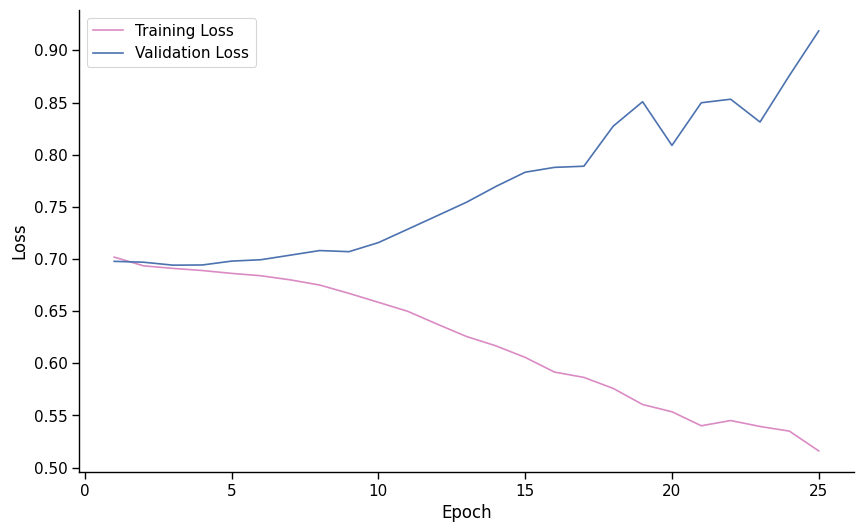

In [ ]:
sns.set_context("paper", font_scale=1.25)
plt.figure(figsize=(10, 6))

sns.set_palette(sns.color_palette("deep")[6::-6])

sns.lineplot(y=epochs_train_loss, x=range(1, num_epochs + 1), label='Training Loss')
sns.lineplot(y=epochs_validation_loss, x=range(1, num_epochs + 1), label='Validation Loss')

sns.despine()
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.title("Loss over epochs")

plt.legend()

# TODO: save the data (both loss and accuracies) to be able to change the plot.
np.save('lstm_train_loss_{}ep_{}lyr_{}hdim.npy'.format(num_epochs, num_layers, hidden_dim), epochs_train_loss)
np.save('lstm_val_loss_{}ep_{}lyr_{}hdim.npy'.format(num_epochs, num_layers, hidden_dim), epochs_validation_loss)

In [ ]:
def plot_accuracies(data: np.ndarray = None, title: str = "", savefile: str = None,
                    downsample_factor: int = 5, washout: int = 0) -> None:
    """
    Plots the mean accuracy over time with confidence band over subjects.
    :param data: 2D numpy array, where each row is the decoding accuracy for one subject over all timesteps.
    :param title: title of the plot.
    :param savefile: file name to save the plot under. If None, no plot is saved.
    :param downsample_factor:
    :param washout:
    :return: None
    """

    df = pd.DataFrame(data=data.T)
    df = df.reset_index().rename(columns={'index': 'Time'})
    df = df.melt(id_vars=['Time'], value_name='Mean_Accuracy', var_name='Subject')

    sns.set_context("paper", font_scale=1.25)

    # Create a seaborn lineplot, passing the matrix directly to seaborn
    plt.figure(figsize=(10, 6))  # Optional: Set the figure size

    sns.set_palette(sns.color_palette("deep"))

    # Create the lineplot, seaborn will automatically calculate confidence intervals
    sns.lineplot(data=df, x=(df['Time'] + washout) * downsample_factor - 1000, y='Mean_Accuracy',
                 errorbar='ci', label='Accuracy')  # BUT confidence band gets much larger with 'sd'
    # Also, it is important to note that MVPA computes CIs over subjects, while the
    # neural nets compute CIs over trials.Higher n makes for narrower CIs, i.e. neural
    # nets will have much narrower CIs without this implying higher certainty.
    sns.despine()

    plt.axhline(y=0.5, color='orange', linestyle='dashdot', linewidth=1, label='Random Chance')
    plt.axvline(x=0, ymin=0, ymax=0.05, color='black', linewidth=1, label='Stimulus Onset')

    # Set plot labels and title
    plt.xlabel('Time (ms)')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(title)

    if savefile is not None:
        plt.savefig('results/{}.png'.format(savefile))

    # Show the plot
    plt.show()

In [ ]:
    with torch.no_grad():
        model.eval()

        trainset_scores = torch.empty(0).to(device)
        trainset_accuracies = torch.empty(0).to(device)
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)[:, washout:, :]

            predictions = outputs >= 0.5
            accuracy = predictions == labels.unsqueeze(-1).unsqueeze(-1).expand(-1, outputs.shape[1], -1)

            outputs[labels == 0] = 1 - outputs[labels == 0]  # invert scores if label is 0 (to represent accuracy)

            trainset_accuracies = torch.cat((trainset_accuracies, accuracy), dim=0)
            trainset_scores = torch.cat((trainset_scores, outputs), dim=0)

        testset_scores = torch.empty(0).to(device)
        testset_accuracies = torch.empty(0).to(device)
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)[:, washout:, :]

            predictions = outputs >= 0.5
            accuracy = predictions == labels.unsqueeze(-1).unsqueeze(-1).expand(-1, outputs.shape[1], -1)

            outputs[labels == 0] = 1 - outputs[labels == 0]  # invert scores if label is 0 (to represent accuracy)

            testset_accuracies = torch.cat((testset_accuracies, accuracy), dim=0)
            testset_scores = torch.cat((testset_scores, outputs), dim=0)

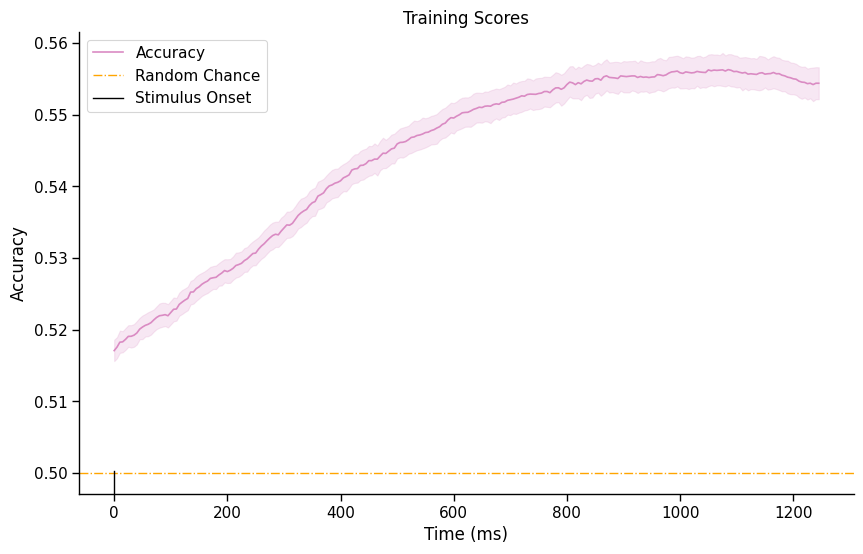

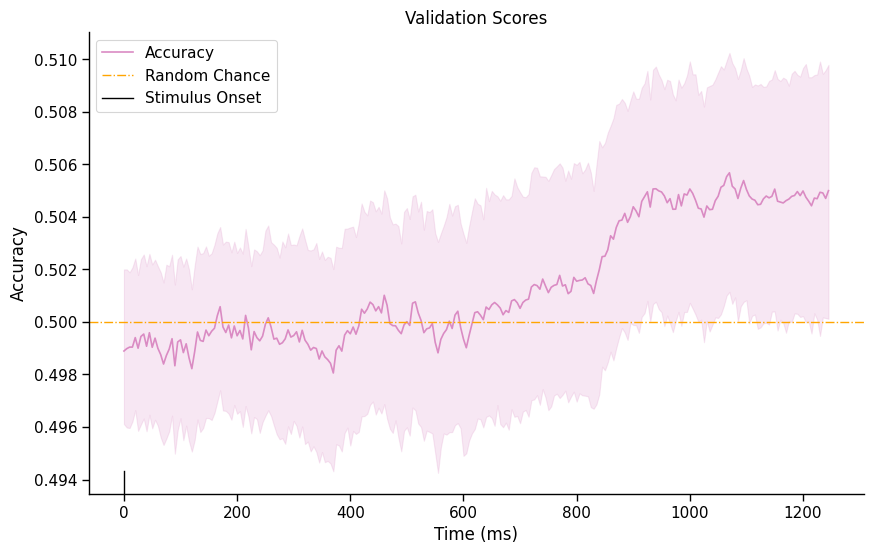

In [ ]:
plot_accuracies(data=trainset_scores.squeeze().cpu().numpy(), title='Training Scores', savefile=None, washout=washout)

plot_accuracies(data=testset_scores.squeeze().cpu().numpy(), title='Validation Scores', savefile=None, washout=washout)

np.save('lstm_train_sco_{}ep_{}lyr_{}hdim{}.npy'.format(num_epochs,
                                                        num_layers,
                                                        hidden_dim,
                                                        '_wd' if weight_decay > 0 else ''),
        trainset_scores.squeeze().cpu().numpy())
np.save('lstm_val_sco_{}ep_{}lyr_{}hdim{}.npy'.format(num_epochs,
                                                      num_layers,
                                                      hidden_dim,
                                                      '_wd' if weight_decay > 0 else ''),
        testset_scores.squeeze().cpu().numpy())

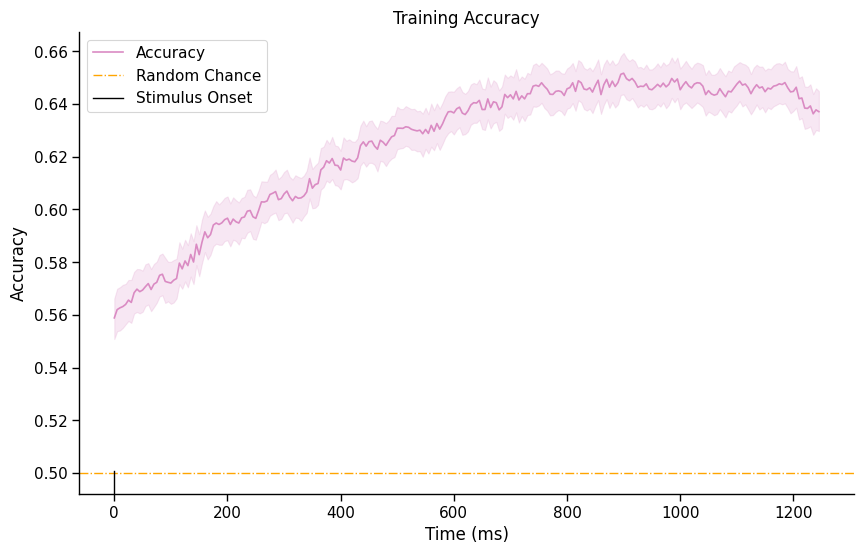

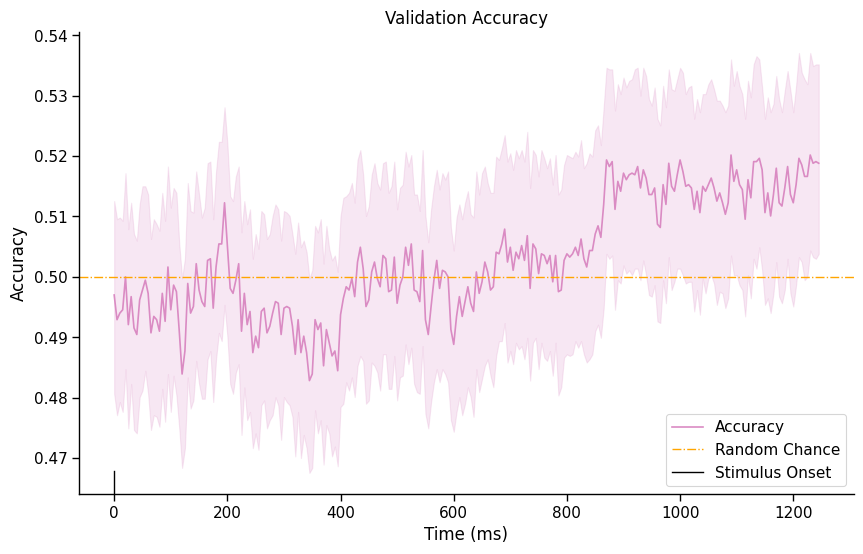

In [ ]:
# TODO: adapt axes of plot (with downsample factor / washout or in method directly)
plot_accuracies(data=trainset_accuracies.squeeze().cpu().numpy(), title='Training Accuracy',
                savefile=None, downsample_factor=downsample_factor, washout=washout)

plot_accuracies(data=testset_accuracies.squeeze().cpu().numpy(), title='Validation Accuracy',
                savefile=None, downsample_factor=downsample_factor, washout=washout)

# TODO: save accuracies as data
np.save('lstm_train_acc_{}ep_{}lyr_{}hdim{}.npy'.format(num_epochs,
                                                 num_layers,
                                                 hidden_dim,
                                                 '_wd' if weight_decay > 0 else ''),
        trainset_accuracies.squeeze().cpu().numpy())
np.save('lstm_val_acc_{}ep_{}lyr_{}hdim{}.npy'.format(num_epochs,
                                               num_layers,
                                               hidden_dim,
                                               '_wd' if weight_decay > 0 else ''),
        testset_accuracies.squeeze().cpu().numpy())